## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

## Read input

In [2]:
import os
os.chdir('/mnt/guanabana/raid/home/slomp006')

# Upload created input and targets to server
# Read dense data
train_inputs = pd.read_csv('Input/Dense/dense_train_input.csv') 
train_targets = pd.read_csv('Input/Dense/dense_train_targets.csv') 

vali_inputs = pd.read_csv('Input/Dense/dense_vali_input.csv') 
vali_targets = pd.read_csv('Input/Dense/dense_vali_targets.csv') 

print(vali_inputs.columns.values,vali_targets.columns.values)

['Unnamed: 0' 'location_id' 'x' 'y' 'date' 'b1' 'b2' 'b3' 'b4' 'b5' 'b6'
 'b7'] ['Unnamed: 0' 'sample_id' 'location_id' 'validation_id' 'reference_year'
 'x' 'y' 'bare' 'crops' 'grassland' 'shrub' 'tree' 'urban_built_up'
 'water' 'dominant_lc']


### Create data from input

In [3]:
# Input features (make sure they are existing columns)
vars = ['x', 'y', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7']

# Output features (targets) (make sure they are existing columns)
targets = ['bare', 'crops',
       'grassland', 'shrub', 'tree', 'urban_built_up', 'water']

# Save IDs to later join them again
IDs = ['sample_id', 'location_id', 'validation_id', 'reference_year',
        'x', 'y']

# Create X (input features) in loop
trainX_list = []
valiX_list = []

for colname in vars: 
  # Get column of feature
  col_train = train_inputs[colname]
  col_vali = vali_inputs[colname]

  # Create train and vali tensor
  var_train = torch.tensor(col_train.values).view(-1, 92, 1) # sequence length now 92 (number of acq. dates in 2015-2018)
  var_vali = torch.tensor(col_vali.values).view(-1, 92, 1)

  # Convert to float32 (used in LSTM)
  var_train = var_train.to(dtype=torch.float32)
  var_vali = var_vali.to(dtype=torch.float32)

  # Append to lists
  trainX_list.append(var_train)
  valiX_list.append(var_vali)

# Do the same for Y (targets)
trainY_list = []
valiY_list = []

for colname in targets: 
  # Get column of feature
  col_train = train_targets[colname]
  col_vali = vali_targets[colname]

  # Create train and vali tensor
  var_train = torch.tensor(col_train.values).view(-1, 4, 1)
  var_vali = torch.tensor(col_vali.values).view(-1, 4, 1)

  # Convert to float32 (used in LSTM)
  var_train = var_train.to(dtype=torch.float32)
  var_vali = var_vali.to(dtype=torch.float32)

  # Append to lists
  trainY_list.append(var_train)
  valiY_list.append(var_vali)

# Save IDs in list
ID_list = []
    
for colname in IDs:
  # Get column of ID
  col_ID = vali_targets[colname]

  # Create tensor
  ID_tensor = torch.tensor(col_ID.values).view(-1, 4, 1)

  # Convert to float32 (used in LSTM)
  ID_tensor = ID_tensor.to(dtype=torch.float32)

  # Append to list
  ID_list.append(ID_tensor)
    
# We now have multiple features as tensors but we want them as one. So concatenate the tensors along the last dimension (2 = -1)
X_train = torch.cat(trainX_list, dim=2)
X_vali = torch.cat(valiX_list, dim=2)
Y_train = torch.cat(trainY_list, dim=2)
Y_vali = torch.cat(valiY_list, dim=2)

ID_vali = torch.cat(ID_list, dim=2)

# Now check if any tensors contain nan values and if so remove them (entire matrix). LSTM will not work (correctly) with nan values.
X_train_old = X_train
X_vali_old = X_vali
Y_train_old = Y_train
Y_vali_old = Y_vali
ID_vali_old = ID_vali

# create an empty mask
mask = None

# If X_train contains nan, apply mask to Y_train and vice versa. Same applies for X and Y_vali.
if torch.isnan(X_train).any():
    mask = torch.isnan(X_train).any(dim=1).any(dim=1)
    X_train = X_train[~mask]
    Y_train = Y_train[~mask] 
if torch.isnan(Y_train).any():
    mask = torch.isnan(Y_train).any(dim=1).any(dim=1) 
    Y_train = Y_train[~mask]
    X_train = X_train[~mask]
if torch.isnan(X_vali).any():
    mask = torch.isnan(X_vali).any(dim=1).any(dim=1) 
    X_vali = X_vali[~mask]
    Y_vali = Y_vali[~mask]
    ID_vali = ID_vali[~mask]
if torch.isnan(Y_vali).any():
    mask = torch.isnan(Y_vali).any(dim=1).any(dim=1) 
    Y_vali = Y_vali[~mask]
    X_vali = X_vali[~mask]
    ID_vali = ID_vali[~mask]

# Check final tensors (including shape)
print("Train X contained nan values:", torch.isnan(X_train_old).any().item(), ", new train X contains nan values:", torch.isnan(X_train).any().item())
print("Old shape of train X:", X_train_old.shape, "New shape: ", X_train.shape, "\n")
print("Train Y contained nan values:", torch.isnan(Y_train_old).any().item(), ", new train Y contains nan values:", torch.isnan(Y_train).any().item())
print("Old shape of train Y:", Y_train_old.shape, "New shape: ", Y_train.shape, "\n")

print("vali X contained nan values:", torch.isnan(X_vali_old).any().item(), ", new vali X contains nan values:", torch.isnan(X_vali).any().item())
print("Old shape of vali X:", X_vali_old.shape, "New shape: ", X_vali.shape, "\n")
print("vali Y contained nan values:", torch.isnan(Y_vali_old).any().item(), ", new vali Y contains nan values:", torch.isnan(Y_vali).any().item())
print("Old shape of vali Y:", Y_vali_old.shape, "New shape: ", Y_vali.shape, "\n")
print("ID vali contained nan values:", torch.isnan(ID_vali_old).any().item(), ", new ID vali contains nan values:", torch.isnan(ID_vali).any().item())
print("Old shape of ID vali:", ID_vali_old.shape, "New shape: ", ID_vali.shape)
print("(ID vali shape should be similar to vali Y (will be joined later))")


Train X contained nan values: False , new train X contains nan values: False
Old shape of train X: torch.Size([33540, 92, 9]) New shape:  torch.Size([33540, 92, 9]) 

Train Y contained nan values: False , new train Y contains nan values: False
Old shape of train Y: torch.Size([33540, 4, 7]) New shape:  torch.Size([33540, 4, 7]) 

vali X contained nan values: True , new vali X contains nan values: False
Old shape of vali X: torch.Size([30712, 92, 9]) New shape:  torch.Size([30674, 92, 9]) 

vali Y contained nan values: False , new vali Y contains nan values: False
Old shape of vali Y: torch.Size([30712, 4, 7]) New shape:  torch.Size([30674, 4, 7]) 

ID vali contained nan values: False , new ID vali contains nan values: False
Old shape of ID vali: torch.Size([30712, 4, 6]) New shape:  torch.Size([30674, 4, 6])
(ID vali shape should be similar to vali Y (will be joined later))


In [5]:
# Indices:   0   ,    1   ,       2    ,    3    ,   4  ,       5         ,    6
targets = ['bare', 'crops', 'grassland', 'shrub', 'tree', 'urban_built_up', 'water']

# Clone original data
X_new, Y_new = X_train.clone(), Y_train.clone()

# See length of original samples
print("Number of original samples:", len(X_train), "\n")
class_counts = [len(Y_new[Y_new[:, -1, i] != 0]) for i in range(len(targets))]
class_counts_100 = [len(Y_new[Y_new[:, -1, i] == 100]) for i in range(len(targets))]
print("Number of original samples per class (where class is > 0):", "\n", 
      *[f"{targets[i]}: {class_counts[i]}" for i in range(len(targets))])
print("Number of original samples per class (where class is == 100):", "\n", 
      *[f"{targets[i]}: {class_counts_100[i]}" for i in range(len(targets))], "\n")

# Function to upsample classes where value is > 0 (thus every sample where class is represented)
def upsample(X, Y, i, n):
    idx = Y[:, -1, i] != 0 # -1 to account for one that is already in the data set
    X_sub = X[idx].repeat(n-1, 1, 1)
    Y_sub = Y[idx].repeat(n-1, 1, 1)
    return X_sub, Y_sub

# Function to only upsample classes where value = 100 (thus every sample where class is 100)
def upsample100(X, Y, i, n):
    idx = Y[:, -1, i] == 100
    X_sub = X[idx].repeat(n-1, 1, 1)
    Y_sub = Y[idx].repeat(n-1, 1, 1)
    return X_sub, Y_sub

# Upsample all urban cases
urban_X, urban_Y = upsample(X_new, Y_new, 5, 5)

# Upsample urban cases where value is 100
urban_100_X, urban_100_Y = upsample100(X_new, Y_new, 5, 100)

# Create upsampled training data
X_new = torch.cat([X_new, urban_X, urban_100_X], dim=0)
Y_new = torch.cat([Y_new, urban_Y, urban_100_Y], dim=0)

# Print new lengths
print("Number of samples after upsampling:", len(X_new), "\n")
new_class_counts = [len(Y_new[Y_new[:, -1, i] != 0]) for i in range(len(targets))]
new_class_counts_100 = [len(Y_new[Y_new[:, -1, i] == 100]) for i in range(len(targets))]
print("Number of samples per class (where class is represented > 0):", "\n", 
      *[f"{targets[i]}: {new_class_counts[i]}" for i in range(len(targets))])
print("Number of original samples per class (where class is == 100):", "\n", 
      *[f"{targets[i]}: {new_class_counts_100[i]}" for i in range(len(targets))])

Number of original samples: 33540 

Number of original samples per class (where class is > 0): 
 bare: 5412 crops: 7159 grassland: 22978 shrub: 16868 tree: 14736 urban_built_up: 2283 water: 3261
Number of original samples per class (where class is == 100): 
 bare: 364 crops: 2102 grassland: 4988 shrub: 670 tree: 1673 urban_built_up: 9 water: 1784 

Number of samples after upsampling: 43563 

Number of samples per class (where class is represented > 0): 
 bare: 8488 crops: 11071 grassland: 30530 shrub: 23436 tree: 21928 urban_built_up: 12306 water: 3889
Number of original samples per class (where class is == 100): 
 bare: 364 crops: 2102 grassland: 4988 shrub: 670 tree: 1673 urban_built_up: 936 water: 1784


#### Regress target data

In [ ]:
def RegressSamples(originalX, originalY):    
    
    # Clone original tensors
    test_Y = originalY.clone().detach()
    test_X = originalX.clone().detach()

    # Save regressed tensor
    regressed_tensor = []

    # Loop over samples
    for sample in range(test_Y.shape[0]):

        # Progress
        print("\rRegressing sample: {}/{}".format(sample, test_Y.shape[0]), end='\r')

        # Create output tensor sample for sample      
        out = torch.zeros(1, 92, 7)

        # If southern hemisphere, place fractions at first months (important, second indice need to translate to Y coord!!)      
        if (test_X[sample, :, 1] < 0).all():

            out[:, 0:5, :] = test_Y[sample, 0, :].unsqueeze(0).unsqueeze(1).repeat_interleave(5, dim=1)
            out[:, 23:28, :] = test_Y[sample, 1, :].unsqueeze(0).unsqueeze(1).repeat_interleave(5, dim=1)
            out[:, 46:51, :] = test_Y[sample, 2, :].unsqueeze(0).unsqueeze(1).repeat_interleave(5, dim=1)
            out[:, 69:, :] = test_Y[sample, 3, :].unsqueeze(0).unsqueeze(1).repeat_interleave(23, dim=1)

            diff1 = (out[:, 23, :] - out[:, 4, :]).unsqueeze(1)
            diff2 = (out[:, 46, :] - out[:, 27, :]).unsqueeze(1)
            diff3 = (out[:, 69, :] - out[:, 50, :]).unsqueeze(1)

            for diff in range(3):

                if diff == 0:
                    diff_timesteps = 23-5
                    start_timestep = 5-1
                    diff_values = diff1
                elif diff == 1:
                    diff_timesteps = 46-28
                    start_timestep = 28-1
                    diff_values = diff2
                else:
                    diff_timesteps = 69-51
                    start_timestep = 51-1
                    diff_values = diff3

                regr_values = []

                for i in range(diff_values.shape[2]):

                    if diff_values[:, :, i] == 0:
                        regr_value = torch.zeros(1, 1).unsqueeze(1)
                    else:
                        regr_value = torch.tensor(diff_values[:, :, i] / diff_timesteps).unsqueeze(1)

                    regr_values.append(regr_value)

                regr_values = torch.cat(regr_values, dim=-1)

                for next_step in range(diff_timesteps):
                    timestep = out[:, start_timestep+next_step, :].unsqueeze(1)
                    out[:, start_timestep+next_step+1, :] = timestep + regr_values

        # If northern hemisphere, place fractions at the middle months      
        else:

            out[:, 0:14, :] = test_Y[sample, 0, :].unsqueeze(0).unsqueeze(1).repeat_interleave(14, dim=1)
            out[:, 32:37, :] = test_Y[sample, 1, :].unsqueeze(0).unsqueeze(1).repeat_interleave(5, dim=1)
            out[:, 55:60, :] = test_Y[sample, 2, :].unsqueeze(0).unsqueeze(1).repeat_interleave(5, dim=1)
            out[:, 78:, :] = test_Y[sample, 3, :].unsqueeze(0).unsqueeze(1).repeat_interleave(14, dim=1)

            diff1 = (out[:, 32, :] - out[:, 13, :]).unsqueeze(1)
            diff2 = (out[:, 55, :] - out[:, 36, :]).unsqueeze(1)
            diff3 = (out[:, 78, :] - out[:, 59, :]).unsqueeze(1)

            for diff in range(3):

                if diff == 0:
                    diff_timesteps = 32-14
                    start_timestep = 14-1
                    diff_values = diff1
                elif diff == 1:
                    diff_timesteps = 55-37
                    start_timestep = 37-1
                    diff_values = diff2
                else:
                    diff_timesteps = 78-60
                    start_timestep = 60-1
                    diff_values = diff3

                regr_values = []

                for i in range(diff_values.shape[2]):

                    if diff_values[:, :, i] == 0:
                        regr_value = torch.zeros(1, 1).unsqueeze(1)
                    else:
                        regr_value = torch.tensor(diff_values[:, :, i] / diff_timesteps).unsqueeze(1)

                    regr_values.append(regr_value)

                regr_values = torch.cat(regr_values, dim=-1)

                for next_step in range(diff_timesteps):
                    timestep = out[:, start_timestep+next_step, :].unsqueeze(1)
                    out[:, start_timestep+next_step+1, :] = timestep + regr_values

        # Append regressed sample to full regressed tensor list      
        regressed_tensor.append(out)

    # Concatenate into full shape [num samples, 92, 7]          
    regressed_tensor = torch.cat(regressed_tensor, dim=0)

    # Return tensor
    return regressed_tensor

# Perform function on data
# Important, indice 1 in argument 1 needs to translate to unnormalised Y coord
Y_regressed = RegressSamples(X_train, Y_train)

print("\n", "We now have regressed", Y_train.shape, "into", Y_regressed.shape)


#### Check

In [7]:
# Check certain sample
i = 236

torch.set_printoptions(sci_mode=False, precision=2, linewidth=100)

print("Original sample:")
print(Y_new[i, :, :].detach(), "\n")
print("Regressed sample:")
print(Y_regressed[i, :, :].detach())

Original sample:
tensor([[  0.,   0., 100.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  23.,  77.,   0.,   0.,   0.]]) 

Regressed sample:
tensor([[  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100.00,   0.00,   0.00,   0.00,   0.00],
        [  0.00,   0.00, 100

### Normalize data

In [8]:
# Keep unnormalised Y coord (indice 1)
X_train_Y_coord = X_train[:, :, 1].unsqueeze(2)
X_new_Y_coord = X_new[:, :, 1].unsqueeze(2)
X_vali_Y_coord = X_vali[:, :, 1].unsqueeze(2)

In [9]:
from torch.utils.data import TensorDataset, random_split

# Use X_train and Y_train for original training data
# Use X_new and Y_new for upsampled training data

# Calculate the mean and standard deviation of each feature in the training set
X_mean = X_train.mean(dim=0)
X_std = X_train.std(dim=0)
Upsampled_X_mean = X_new.mean(dim=0)
Upsampled_X_std = X_new.std(dim=0)

# Standardize the training set
X_train = (X_train - X_mean) / X_std
X_new = (X_new - Upsampled_X_mean) / Upsampled_X_std

# Standardize the vali set using the mean and standard deviation of the training set
X_vali = (X_vali - Upsampled_X_mean) / Upsampled_X_std

# Bind unnormalised Y coord with normalised data
X_train_plusCoord = torch.cat([X_train_Y_coord, X_train], dim=-1)
X_new_plusCoord = torch.cat([X_new_Y_coord, X_new], dim=-1)
X_vali_plusCoord = torch.cat([X_vali_Y_coord, X_vali], dim=-1)

# Create the TensorDataset for the training set
train_dataset = TensorDataset(X_train_plusCoord, Y_train)
upsampled_train_dataset = TensorDataset(X_new_plusCoord, Y_new)
regressed_train_dataset = TensorDataset(X_train_plusCoord, Y_regressed)

# Split
train_size = int(0.8 * X_train_plusCoord.size(0)) 
test_size = X_train_plusCoord.size(0) - train_size

# Training test data set
train_dataset, test_dataset = random_split(regressed_train_dataset, [train_size, test_size])

# Create the TensorDataset for the vali set
vali_dataset = TensorDataset(X_vali_plusCoord, Y_vali)

## Define and apply LSTM model

In [10]:
# Optimizer: Adam, LR: 0.001, hidden size: 256, epochs = 100, batch size = 64, no activation (SmoothL1 loss) (non-dense)

import torch.optim as optim
import torch.nn.init as init

# Bidirectional LSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super().__init__()
        # LSTM 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Activation
        self.activation = nn.Tanh()
        
        # Linear with Xavier Uniform
        self.linear = nn.Linear(hidden_size*2, output_size) # x2 (bidirectional)
#         init.xavier_uniform_(self.linear.weight)
        
        # Softmax
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x_input):
        
        # Don't use Y coordinate (first indice)
        x = x_input[:, :, 1:]
        
        # Put input through LSTM layer
        x, _ = self.lstm(x)
        
        # Put LSTM output through dropout layer (prevent overfitting)
        x = self.dropout(x)
        
        # Apply tanh activation function
        x = self.activation(x)
        
        # Linear transform x to shape [batch size, sequence length = 92, output size = 7]
        x = self.linear(x)
        
        # Make sure output distribution sums to 100
        x = self.softmax(x) * 100
        
        # Create two outputs: dense and aggregated
        # Aggregate based on Y > 0 (northern hemisphere) and Y < 0 (southern hemisphere)
        agg_batch = []
        for i in range(x_input.shape[0]):
            if (x_input[i, :, 0] > 0).all(): # indice 1 is Y coordinate
                mean1 = x[i, 9:13,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                mean2 = x[i, 32:36,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                mean3 = x[i, 55:59,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                mean4 = x[i, 78:82,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                agg_sample = torch.cat([mean1, mean2, mean3, mean4], dim=1) # [1, 4, 7]
                agg_batch.append(agg_sample)      
            else:
                mean1 = x[i, 0:4,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                mean2 = x[i, 23:27,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                mean3 = x[i, 46:50,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                mean4 = x[i, 69:73,:].unsqueeze(0).mean(dim=1).unsqueeze(1)
                agg_sample = torch.cat([mean1, mean2, mean3, mean4], dim=1) # [1, 4, 7]
                agg_batch.append(agg_sample)  
        
        x_agg = torch.cat(agg_batch, dim=0)
        
        return x, x_agg


In [11]:
# Custom loss function
def customloss(input, target):
    dom_samples_idx = target[:, -1, -1] > 70
    dom_input = input[~dom_samples_idx]
    dom_target = target[~dom_samples_idx]

    if dom_input.numel() > 0:
        kldiv_loss = nn.KLDivLoss(reduction="batchmean")(torch.log(dom_input), dom_target)  
    else:
        kldiv_loss = nn.KLDivLoss(reduction="batchmean")(torch.log(input), target)
    
    l1 = nn.L1Loss()(input, target)
    
#     return (kldiv_loss/input.size(0))+l1
    return nn.KLDivLoss(reduction="batchmean")(torch.log(input), target)
       
# loss_fn = customloss
loss_fn = nn.L1Loss()

#### Train/run model

In [ ]:
# Number of input and output features
input_number = len(vars)
output_number = len(targets)

# Instantiate the model
model = BiLSTMModel(input_size=input_number, hidden_size=256, output_size=output_number)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Create a DataLoader for the training set and validation sets (specify batch size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=True)
vali_loader = torch.utils.data.DataLoader(vali_dataset, batch_size=256, shuffle=False)

# Make lists to retain loss
losses_train_epochs = []
losses_test_epochs = []

# But retain only the best prediction (to save memory)
best_loss = float("inf")
mae = float("inf")
best_pred = []
best_epoch = 0

# Epochs
num_epochs = 300 # The higher, the longer it takes but the better idea of the model's fitting ability
    
# Loop over the training data
for epoch in range(num_epochs):
    
    # Progress
    print("\rAt epoch: {}/{}, Best loss: {} (obtained at epoch {})".format(epoch, 
                                                                            num_epochs, 
                                                                            round(best_loss, 3),
                                                                            best_epoch), end='\r')

    # Loss per epoch
    epoch_trainloss = []
    epoch_testloss = []

    # Predictions per epoch
    epoch_pred_agg = []
    epoch_pred_dense = []
    epoch_actual = []
    epoch_pred_tensor = []
    epoch_actual_tensor = []
    
    # Set the model to training mode  
    model.train()

    # Loop over the training set
    for X, Y in train_loader:
        
        # Repeat Y 23 times, not if it is already regressed
        if Y.shape[1] < 91:
            Y = Y.repeat_interleave(repeats=23, dim=1)
        else:
            Y = Y

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        Y_pred, _ = model(X)

        # Compute the loss
        loss = loss_fn(Y_pred, Y)

        # Backward pass
        loss.backward()

        # Append the loss to the lists
        epoch_trainloss.append(loss.item())
        
        # Update the parameters
        optimizer.step()
       
    with torch.no_grad():  
        
        # Set the model to evaluation mode
        model.eval()
        
        # Loop over the test data set
        for X, Y in test_loader:
            
            # Repeat Y 23 times, not if it is already regressed
            if Y.shape[1] < 91:
                Y = Y.repeat_interleave(repeats=23, dim=1)
            else:
                Y = Y

            # Forward pass
            Y_pred_dense, _ = model(X)

            # Compute the loss     
            loss = loss_fn(Y_pred_dense, Y)

            # Append the loss to the list
            epoch_testloss.append(loss.item())

        # Make predictions
        # Loop over the vali data set
        for X, Y in vali_loader:

            # Forward pass
            Y_pred_dense, Y_pred_agg = model(X)

            # Store predictions for batch
            Y_pred_dense_list = [x.tolist() for x in Y_pred_dense]
            Y_pred_agg_list = [x.tolist() for x in Y_pred_agg]
            Y_list = [x.tolist() for x in Y]

            # Add batch prediction to list 
            epoch_pred_dense.append(Y_pred_dense_list)
            epoch_pred_agg.append(Y_pred_agg_list)
            epoch_actual.append(Y_list)

            # Retain tensors per batch
            epoch_pred_tensor.append(Y_pred_agg)
            epoch_actual_tensor.append(Y)
    
    # Add epoch losses to total loss list 
    losses_train_epochs.append(epoch_trainloss)
    losses_test_epochs.append(epoch_testloss)

    # Check if the current epoch achieved the lowest observed loss, if so, save epoch prediction
    if (sum(epoch_testloss) / len(test_loader)) < best_loss:
        best_loss = sum(epoch_testloss) / len(test_loader)
        best_pred = epoch_pred_agg
        best_pred_dense = epoch_pred_dense
        best_actual = epoch_actual
        best_epoch = epoch
        
        # In case of crash, save dicts
#         torch.save(model.state_dict(), "LSTM/Model Dicts/Dense_model_dict.pt")
#         torch.save(optimizer.state_dict(), "LSTM/Model Dicts/Dense_optim_dict.pt")

print("\n", "Done")
        

## See losses
Take prediction from epoch with lowest validation (vali) loss

The lowest loss: 9.78 is found at epoch: 121 



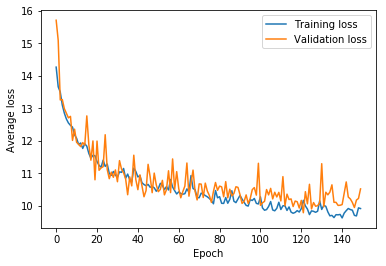

In [75]:
# Average loss per epoch
ltrain_epochs = []
for epoch_list in losses_train_epochs:
  epoch_avg = sum(epoch_list) / len(train_loader)
  ltrain_epochs.append(epoch_avg)

ltest_epochs = []
for epoch_list in losses_test_epochs:
  epoch_avg = sum(epoch_list) / len(vali_loader)
  ltest_epochs.append(epoch_avg)

# Print epoch achieving minimum vali loss
min_value = min(ltest_epochs)
min_index = ltest_epochs.index(min_value)

print("The lowest loss:", round(min_value,2), "is found at epoch:", min_index, "\n")

# Plot the losses over time
plt.plot(ltrain_epochs, label="Training loss")
plt.plot(ltest_epochs, label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.legend()
plt.show()

## See (and check) predictions

In [ ]:
import math
from statistics import mean
from sklearn.metrics import mean_squared_error

# # Make lists of predictions and actual fractions (reference)
nested_pred = best_pred # results from the epoch with the minimum loss is taken
nested_actual = best_actual

unnested_pred = []
for data in nested_pred:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_pred.append(timestep[target])

unnested_actual = []
for data in nested_actual:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_actual.append(timestep[target])

# These lists contain output for entire predictions 
# Now retain lists for each class
pred_class = {}
true_class = {}

# Also retain dense predictions
pred_dense_class = {}
nested_dense_pred = best_pred_dense

unnested_dense_pred = []
for data in nested_dense_pred:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_dense_pred.append(timestep[target])

# Initialize lists for each class in predictions
for i in range(len(targets)):
  pred_class[f'{targets[i]}'] = unnested_pred[i::len(targets)]

# And dense
for i in range(len(targets)):
  pred_dense_class[f'{targets[i]}'] = unnested_dense_pred[i::len(targets)]

# Initialize lists for each class in reference data
for i in range(len(targets)):
  true_class[f'{targets[i]}'] = unnested_actual[i::len(targets)]

RMSEavg = 0
MAEavg = 0

# Plot the lists as graphs

# Loop through the data and plot the actual and predicted values
for i in range(len(targets)):
    # Get the data for the current class
    true = true_class[f'{targets[i]}']
    predicted = pred_class[f'{targets[i]}']

    # Define the x-axis data as a range of values from 0 to the length of the data
    x = range(len(true))

    # Create a new figure
    fig = plt.figure(i)

    # Create a figure with certain size
    fig = plt.figure(figsize=(20, 3))

    # Create axes
    ax = fig.add_subplot(1, 1, 1)

    # Plot the actual and predicted values
    ax.plot(x, true, label='Actual')
    ax.plot(x, predicted, label='Predicted')

    # Add a legend
    ax.legend()

    # Set the title using the class name
    var_name = f'{targets[i]}'
    ax.set_title(var_name)

    # Show the figure
    plt.show()

    # Print RMSE / MAE
    rmse = mean_squared_error(predicted, true) ** 0.5
    RMSEavg = RMSEavg + rmse
    print(f'RMSE for {var_name}: {round(rmse, 2)}')

    difference = [abs(predicted - true) for predicted, true in zip(predicted, true)]
    mae = mean(difference)
    MAEavg = MAEavg + mae
    print(f'MAE for {var_name}: {round(mae, 2)}')

print("\n")
RMSEavg = RMSEavg / len(targets)
MAEavg = MAEavg / len(targets)

print(f'Average RMSE is {round(RMSEavg, 2)} and average MAE is {round(MAEavg, 2)}')

## Create prediction data frame and write to file

In [ ]:
import pandas as pd

# # Make lists of predictions and actual fractions (reference)
nested_pred = best_pred # results from the epoch with the minimum loss is taken
nested_actual = best_actual

unnested_pred = []
for data in nested_pred:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_pred.append(timestep[target])

unnested_actual = []
for data in nested_actual:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_actual.append(timestep[target])

# These lists contain output for entire predictions 
# Now retain lists for each class
pred_class = {}
true_class = {}

# Also retain dense predictions
pred_dense_class = {}
nested_dense_pred = best_pred_dense

unnested_dense_pred = []
for data in nested_dense_pred:
  for batch in data:
    for timestep in batch:
      for target in range(len(timestep)):
        unnested_dense_pred.append(timestep[target])

# Initialize lists for each class in predictions
for i in range(len(targets)):
  pred_class[f'{targets[i]}'] = unnested_pred[i::len(targets)]

# And dense
for i in range(len(targets)):
  pred_dense_class[f'{targets[i]}'] = unnested_dense_pred[i::len(targets)]

# Initialize lists for each class in reference data
for i in range(len(targets)):
  true_class[f'{targets[i]}'] = unnested_actual[i::len(targets)]


# Add IDs (vali data was not shuffled so can add like this --- checked with excel!)
# First need to increase rows (as was done with the other data)
ID_tensor = ID_vali.repeat_interleave(repeats=23, dim=1)

# This was the order of columns we made the tensor
column_names = ['sample_id', 'location_id', 'validation_id', 'reference_year',
                'x', 'y']

# make the ID tensor to a shape with correct amount rows and columns
ID_array = ID_vali.numpy().reshape(-1,len(column_names))
ID_array_dense = ID_tensor.numpy().reshape(-1,len(column_names))

# Create dfs (also create vali df)
pred_df = pd.DataFrame(ID_array, columns=column_names)
dense_pred_df = pd.DataFrame(ID_array_dense, columns=column_names)
# pred_df = pd.DataFrame(ID_vali, columns=column_names)
# dense_pred_df = pd.DataFrame(ID_array, columns=column_names)

# Adds predictions to df 
for i in range(len(targets)):
    data = pred_class[f'{targets[i]}']
    data_dense = pred_dense_class[f'{targets[i]}']

    pred_df[targets[i]] = data 
    dense_pred_df[targets[i]] = data_dense 

# Show df
# pred_df.head(12)

## Write to file

In [15]:
# Prediction
pred_df.to_csv('Output/LSTM/LSTM_dense_to_agg.csv')
dense_pred_df.to_csv('Output/LSTM/LSTM_dense.csv')